In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

In [2]:
Train_dir = 'C:/Users/Hrishikesh M Rao/Documents/archive (1)/ck/CK+48'
emotions_loc = 'C:/Users/Hrishikesh M Rao/Documents/archive (1)/ck/CK+48'

In [3]:
images = []
labels = []
i=0
for emotions in os.listdir(Train_dir):
    emotion_path = os.path.join(emotions_loc,emotions)
    for filename in os.listdir(emotion_path):
        if filename.endswith('.png'):
            image_path = os.path.join(emotion_path, filename)
            image = Image.open(image_path)
            desired_size = (224, 224)
            image = image.resize(desired_size)
            image = np.array(image)
            image = image / 255.0
            images.append(image)
            label = np.zeros(7)
            label[i] = 1
            labels.append(label)
    i+=1       

The shape of the images list is = (981, 224, 224)
The size of the images list is = 49222656
[1. 0. 0. 0. 0. 0. 0.]


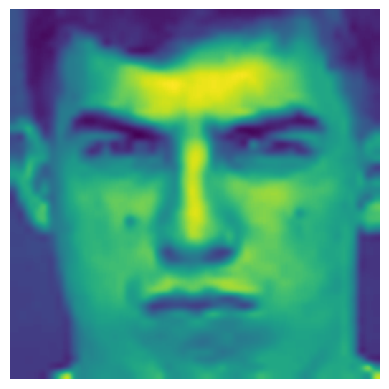

In [4]:
print("The shape of the images list is = "+str(np.shape(images)))
print("The size of the images list is = "+str(np.size(images)))

print(labels[i])
i = 98 
plt.imshow(images[i])
plt.axis('off')  # Hide axis labels and ticks
plt.show()


## Reshape the images and label matrix as necessary

In [5]:

images = np.transpose(images, (1, 2, 0))
images = images.reshape(224*224,981)
labels = np.array(labels)
labels = np.transpose(labels,(1,0))

# Shuffle the dataset
num_samples = images.shape[1]
indices = np.arange(num_samples)
np.random.shuffle(indices)
images = images[:,indices]
labels = labels[:,indices]



[0. 0. 1. 0. 0. 0. 0.]


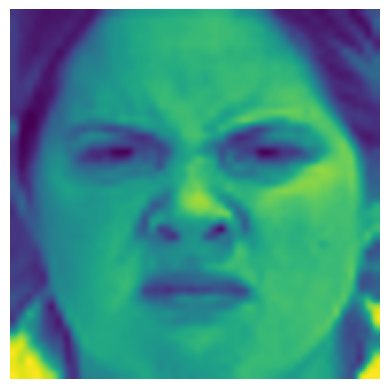

In [6]:
print(labels[:,i])
i = 98  # Change this to the index of the image you want to plot

# Select the column corresponding to the ith image
selected_image = images[:, i]

# Reshape the selected image back to its original shape (224x224)
original_shape_image = selected_image.reshape(224, 224)

plt.imshow(original_shape_image)
plt.axis('off')  # Hide axis labels and ticks
plt.show()

## Normalizer

In [7]:
def Normalise(parameter):

    mean = np.mean(parameter)
    std = np.std(parameter)
    parameter = (parameter-mean)/(std)
    
    return parameter

In [17]:
images = Normalise(images)

## Initialise W and b for every node of each layer

In [9]:
def initialize_parameters(layers): 
    parameters = {}
    L = len(layers)
    for l in range(1, L):
        
        parameters['W' + str(l)] = np.random.randn(layers[l],layers[l-1])
        parameters['W'+str(l)] = Normalise(parameters['W' + str(l)])
        
        parameters['b' + str(l)] = np.zeros((layers[l],1))
    
    return parameters

## The Activation Fuctions

In [10]:
def sigmoid(Z):
    a = 1/(1+np.exp(-Z))
    return a

def relu(Z):
    a = np.maximum(0,Z)
    return a

def soft_max(Z):
    exp = np.exp(Z-np.max(Z))
    a = exp/(np.sum(exp,axis=1,keepdims=True))
    return a

## Propagate forward

In [11]:
def forward_propagation(images,parameters):
    
    cache = {}
    L= int(len(parameters)/2)
    
    cache['Z'+str(1)] = (np.dot(parameters['W'+str(1)],images))+parameters['b'+str(1)]
    cache['A'+str(1)] = relu(cache['Z'+str(1)])
    cache['A'+str(1)] = Normalise(cache['A'+str(1)])
    
    for l in range(2,L):
        cache['Z'+str(l)] = (np.dot(parameters['W'+str(l)],cache['A'+str(l-1)]))+parameters['b'+str(l)]
        cache['A'+str(l)] = relu(cache['Z'+str(l)])
        cache['A'+str(l)] = Normalise(cache['A'+str(l)])
        
    cache['Z'+str(L)] = (np.dot(parameters['W'+str(L)],cache['A'+str(L-1)]))+parameters['b'+str(L)]
    cache['A'+str(L)] = soft_max(cache['Z'+str(L)])
    
    A4 = cache['A'+str(L)]

    return A4,cache


## Loss Function

In [12]:
def compute_loss(A4,labels,epsilon):
    
    m = labels.shape[1]
    cost = -(np.sum(labels*np.log(A4+epsilon)))/m
    
    return cost

## Gradient Decent

In [13]:
def backward_propagation(images, labels, cache, parameters):
    
    grads={}
    m=images.shape[1]
    L = int(len(cache)/2)
    grads['dZ'+str(L)] =  (labels-cache['A'+str(L)])/m
    grads['dW'+str(L)] = np.dot(grads['dZ'+str(L)],cache['A'+str(L-1)].T)/m
    grads['db'+str(L)] = np.sum(grads['dZ'+str(L)],axis=1,keepdims=True)/m #sum by the rows of dZ with keepdims=True 
    for l in range(L-1,1,-1):
        grads['dA'+str(l)] = cache['A'+str(l)]/cache['Z'+str(l)]
        grads['dZ'+str(l)] = np.dot(parameters['W'+str(l+1)].T,grads['dZ'+str(l+1)])*grads['dA'+str(l)]
        grads['dW'+str(l)] = np.dot(grads['dZ'+str(l)],cache['A'+str(l-1)].T)/m
        grads['db'+str(l)] = np.sum(grads['dZ'+str(l)],axis=1,keepdims=True)/m #sum by the rows of dZ with keepdims=True
        
    grads['dA'+str(1)] = cache['A'+str(1)]/cache['Z'+str(1)]
    grads['dZ'+str(1)] = np.dot(parameters['W'+str(2)].T,grads['dZ'+str(1+1)])*grads['dA'+str(1)]
    grads['dW'+str(1)] = np.dot(grads['dZ'+str(1)],images.T)/m
    grads['db'+str(1)] = np.sum(grads['dZ'+str(1)],axis=1,keepdims=True)/m #sum by the rows of dZ with keepdims=True
    
    return grads

## Update Parameters

In [14]:
def update_parameters(parameters, grads, learning_rate):
    
    L = int(len(parameters)/2)
    for l in range(L):
        
        parameters['W'+str(l+1)]= (parameters['W'+str(l+1)])-(learning_rate*grads['dW'+str(l+1)])
        
        parameters['b'+str(l+1)]= (parameters['b'+str(l+1)])-(learning_rate*grads['db'+str(l+1)])
        
    return parameters

In [15]:
def calculate_accuracy(true_labels, A4):
    
    # Ensure that the input arrays have the same shape
    assert true_labels.shape == A4.shape, "Input shapes do not match"
    
    # Calculate the number of correct predictions
    mask1 = (np.abs(true_labels-A4)<=0.25)
    mask2 = (np.all(mask1,axis=0))

    # Count the total number of times 1 appears using the mask
    num_correct = np.sum(mask2)
    
    # Calculate the total number of samples
    total_samples = true_labels.shape[1]

    # Calculate accuracy
    accuracy = (num_correct*100) / total_samples
    
    return accuracy

## Combine all the functions to create a working model

In [16]:
def predictor(images, labels, learning_rate, num_iterations=15000, print_cost = True, epsilon = 1e-15):
    grads = {}
    costs = []
    layers = [images.shape[0],10,10,10,labels.shape[0]]
    # Initialse w and b
    parameters=initialize_parameters(layers)
    
    for i in range(0, num_iterations):
        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        A4, cache = forward_propagation(images, parameters)
        
        # Loss
        cost = compute_loss(A4, labels, epsilon)

        # Backward propagation.
        grads = backward_propagation(images, labels, cache, parameters)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i % 1000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
            costs.append(cost)
            accuracy = calculate_accuracy(labels, A4)
            print("Accuracy:", accuracy, "%")  
                 
        # plot the loss
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters 

Cost after iteration 0: 8.984398048397885
Accuracy: 0.0 %
Cost after iteration 1000: 9.047979741837084
Accuracy: 0.0 %
Cost after iteration 2000: 10.32909929738518
Accuracy: 0.0 %
Cost after iteration 3000: 10.15979376700633
Accuracy: 0.0 %
Cost after iteration 4000: 9.096784959366765
Accuracy: 0.0 %
Cost after iteration 5000: 9.113127281793771
Accuracy: 0.0 %
Cost after iteration 6000: 9.099302168486082
Accuracy: 0.0 %
Cost after iteration 7000: 8.833350624158808
Accuracy: 0.0 %
Cost after iteration 8000: 8.872962856115581
Accuracy: 0.0 %
Cost after iteration 9000: 8.69920918421395
Accuracy: 0.0 %
Cost after iteration 10000: 8.764726281288768
Accuracy: 0.0 %
Cost after iteration 11000: 8.966258919753997
Accuracy: 0.0 %
Cost after iteration 12000: 9.033181617639187
Accuracy: 0.0 %
Cost after iteration 13000: 9.11993311394409
Accuracy: 0.0 %
Cost after iteration 14000: 9.166787149156834
Accuracy: 0.0 %


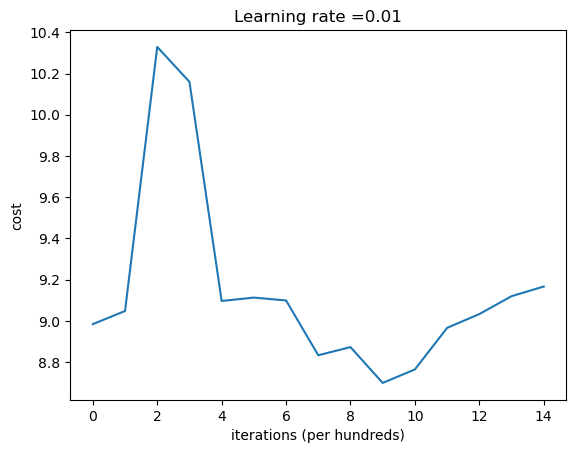

{'W1': array([[ 0.04455132,  1.4740032 ,  1.35561476, ...,  0.98960734,
         -0.16119769,  0.30164888],
        [-0.80213993, -1.35148764, -0.37936352, ..., -1.11378228,
          0.00735373,  0.88324352],
        [-0.81776266,  2.22271316, -1.35454714, ...,  1.3304301 ,
          2.07555676,  0.65456829],
        ...,
        [ 0.4282285 , -0.63876297, -1.49193388, ..., -0.13150049,
          0.85127163,  1.45064531],
        [-1.0848833 ,  0.37609096, -0.87032913, ...,  0.42220424,
          1.57812612, -0.20193703],
        [-0.37724838, -1.10751106, -1.59765632, ..., -0.8121562 ,
          0.97056595, -1.70270322]]),
 'b1': array([[-0.09067868],
        [-0.05417412],
        [ 0.01758955],
        [-0.00205798],
        [-0.01976342],
        [-0.00154221],
        [-0.05116576],
        [-0.00097054],
        [-0.03812768],
        [ 0.0050371 ]]),
 'W2': array([[ 0.72644606, -0.37947773, -1.75555931,  0.24479317,  0.98846677,
         -0.12720965,  0.83258632, -0.56457011, -

In [20]:
predictor(images, labels, learning_rate = 0.01)


